# Importing and Tidying the Data

In [18]:
# import stuff
import numpy as np
import pandas as pd

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk")
%matplotlib inline

In [20]:
#import the data from csv file with a series of NAN values 
df1 = pd.read_csv('./../data/highered_00004.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )
df1 = df1.drop(['REFID'], axis=1)
df2 = pd.read_csv('./../data/highered_00007.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )
df = df1.merge(df2,  on=['PERSONID', 'YEAR', 'WEIGHT', 'SAMPLE', 'SURID'])

In [21]:
# explanation of the survey https://highered.ipums.org/highered/survey_designs.shtml

# Respondents from each of these three surveys with science or engineering degrees                               ##
# or occupations are compiled into one dataset: the SESTAT (the Scientists and Engineers Statistical Data System)##

df.info(3)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 478747 entries, 0 to 478746
Data columns (total 46 columns):
PERSONID    478747 non-null int64
YEAR        478747 non-null int64
WEIGHT      478737 non-null float64
SAMPLE      478747 non-null int64
SURID       478747 non-null int64
AGE         478747 non-null int64
BIRYR       478747 non-null int64
GENDER      478747 non-null int64
MINRTY      478747 non-null int64
RACETH      478747 non-null int64
BTHUS       478747 non-null int64
CTZUSIN     478747 non-null int64
CTZUS       438777 non-null float64
FNVS        20573 non-null float64
CHTOT       219740 non-null float64
BA03Y5      465491 non-null float64
NBAMED      463945 non-null float64
NBAMEMG     465494 non-null float64
DGRDG       478747 non-null int64
HD03Y5      478747 non-null int64
NDGMED      478747 non-null int64
NDGMEMG     478747 non-null int64
LFSTAT      478747 non-null int64
WRKG        478747 non-null int64
HRSWKGR     407478 non-null float64
WKSWKGR     407478 non-n

In [22]:
df_employed = df[df['LFSTAT']==1]
df_employed_small = df_employed.drop(['CTZUS', 'WEIGHT', 'WRKG', 'NRREA','FNVS', 'CHTOT', 'CPI2009C', 'PERSONID', 'LFSTAT','BA03Y5', 'LOOKWK'], axis=1)
df_employed_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407478 entries, 0 to 478746
Data columns (total 35 columns):
YEAR        407478 non-null int64
SAMPLE      407478 non-null int64
SURID       407478 non-null int64
AGE         407478 non-null int64
BIRYR       407478 non-null int64
GENDER      407478 non-null int64
MINRTY      407478 non-null int64
RACETH      407478 non-null int64
BTHUS       407478 non-null int64
CTZUSIN     407478 non-null int64
NBAMED      394508 non-null float64
NBAMEMG     395942 non-null float64
DGRDG       407478 non-null int64
HD03Y5      407478 non-null int64
NDGMED      407478 non-null int64
NDGMEMG     407478 non-null int64
HRSWKGR     407478 non-null float64
WKSWKGR     407478 non-null float64
OCEDRLP     407478 non-null float64
NOCPR       407478 non-null float64
NOCPRMG     407478 non-null float64
SALARY      407478 non-null float64
JOBSATIS    407478 non-null float64
EMSEC       407478 non-null float64
EMSIZE      407478 non-null float64
GOVSUP      40478

In [23]:
#df_employed_l = df_employed_small[df_employed_small.SALARY != 150000]
df_employed_l = df_employed_small.dropna()

df_employed_l.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391928 entries, 0 to 478746
Data columns (total 35 columns):
YEAR        391928 non-null int64
SAMPLE      391928 non-null int64
SURID       391928 non-null int64
AGE         391928 non-null int64
BIRYR       391928 non-null int64
GENDER      391928 non-null int64
MINRTY      391928 non-null int64
RACETH      391928 non-null int64
BTHUS       391928 non-null int64
CTZUSIN     391928 non-null int64
NBAMED      391928 non-null float64
NBAMEMG     391928 non-null float64
DGRDG       391928 non-null int64
HD03Y5      391928 non-null int64
NDGMED      391928 non-null int64
NDGMEMG     391928 non-null int64
HRSWKGR     391928 non-null float64
WKSWKGR     391928 non-null float64
OCEDRLP     391928 non-null float64
NOCPR       391928 non-null float64
NOCPRMG     391928 non-null float64
SALARY      391928 non-null float64
JOBSATIS    391928 non-null float64
EMSEC       391928 non-null float64
EMSIZE      391928 non-null float64
GOVSUP      39192

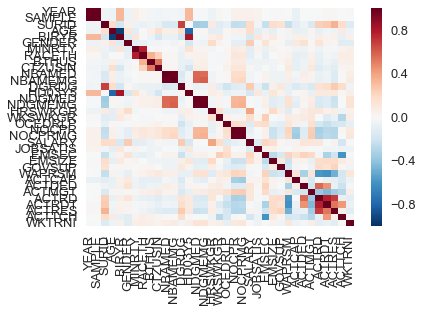

In [24]:
sns.heatmap(df_employed_l.corr())

In [25]:
df_employed_l.corr()['SALARY']

YEAR        0.047753
SAMPLE      0.049694
SURID       0.193761
AGE         0.186057
BIRYR      -0.162161
GENDER      0.257586
MINRTY     -0.102562
RACETH     -0.101382
BTHUS      -0.055799
CTZUSIN     0.012500
NBAMED     -0.037537
NBAMEMG    -0.034085
DGRDG       0.263496
HD03Y5     -0.167808
NDGMED     -0.010046
NDGMEMG    -0.001453
HRSWKGR     0.403946
WKSWKGR     0.176768
OCEDRLP    -0.128177
NOCPR      -0.091245
NOCPRMG    -0.056801
SALARY      1.000000
JOBSATIS   -0.140447
EMSEC       0.215927
EMSIZE      0.169909
GOVSUP      0.022820
WAPRSM     -0.034008
ACTCAP      0.042460
ACTDED      0.126313
ACTMGT      0.119822
ACTRD       0.115217
ACTRDT     -0.012041
ACTRES      0.036424
ACTTCH     -0.183005
WKTRNI      0.007476
Name: SALARY, dtype: float64

In [26]:
df_employed_d = pd.get_dummies(df_employed_l, columns=['RACETH','NBAMED', 'NBAMEMG', 'NDGMED', 'EMSEC','EMSIZE', 'GOVSUP', 'NDGMEMG', 'OCEDRLP', 'WAPRSM','WKTRNI', 'NOCPR', 'NOCPRMG', 'SAMPLE', 'HD03Y5', 'DGRDG', 'JOBSATIS'], drop_first=True)
X = df_employed_d.drop(['SALARY'], axis=1)
y = df_employed_d['SALARY']

In [39]:
#import the machine learning algorithm packages
# Import modules of linear regresssion, evaluation, and train test split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# Import Lasso
from sklearn.linear_model import Lasso
# Import Ridge
from sklearn.linear_model import Ridge


#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the regressor: reg
reg = Ridge(alpha=100)


# Fit the model to the data
reg.fit(X_train,y_train)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(X_test)

# Print R^2 
print(reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))


0.506172858338
Root Mean Squared Error: 27800.74982108728


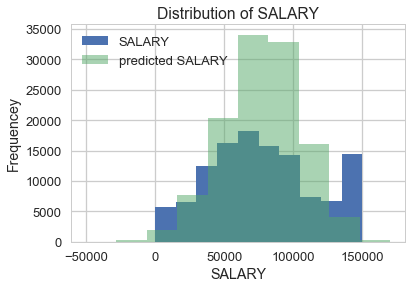

In [28]:
# your turn

plt.hist(y_test, label='SALARY')
plt.hist(y_pred, alpha=0.5, label='predicted SALARY')
plt.title("Distribution of SALARY")
plt.legend()
plt.xlabel("SALARY")
plt.ylabel("Frequencey")
plt.show()

In [47]:
# your turn
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary() )
#m3 = ols(formula='SALARY ~ ALL',data = df_employed_d).fit()
#print(m3.summary())

                            OLS Regression Results                            
Dep. Variable:                 SALARY   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     3161.
Date:                Thu, 12 Apr 2018   Prob (F-statistic):               0.00
Time:                        20:52:45   Log-Likelihood:            -4.5674e+06
No. Observations:              391928   AIC:                         9.135e+06
Df Residuals:                  391801   BIC:                         9.136e+06
Df Model:                         126                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
YEAR               33.5226     31.822     

In [ ]:
# Import necessary modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
param_grid = {"n_estimators": [10, 30, 50],
              "max_features": [10, 30],
              "max_depth": [10, 100, 300]
              }

# Instantiate a logistic regression classifier: logreg
rfr = RandomForestRegressor()

# Instantiate the GridSearchCV object: logreg_cv
rfr_cv = GridSearchCV(rfr, param_grid, cv=5)

# Fit it to the data
rfr_cv.fit(X_train,y_train)

y_rfr_cv = rfr_cv.predict(X_test)

rmse_rfr_cv = np.sqrt(mean_squared_error(y_test,y_rfr_cv))

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfr_cv.best_params_)) 
print("Best score is {}".format(rfr_cv.best_score_))

# test data result
print("Score on the test data is: ", rfr_cv.score(X_test, y_test))

# Print RMSE
print("RBF Root Mean Squared Error: {}".format(rmse_rfr_cv))

In [46]:
## Trying random forest regressor

from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, max_features=20, max_depth=200)

y_rfr = rfr.fit(X_train, y_train).predict(X_test)

rmse_rfr = np.sqrt(mean_squared_error(y_test,y_rfr))

# Print R^2 
print(rfr.score(X_test, y_test))

# Print RMSE
print("RBF Root Mean Squared Error: {}".format(rmse_rfr))


0.568626558394
RBF Root Mean Squared Error: 25983.38529301808


In [ ]:
## Trying SVR 
from sklearn.svm import SVR

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
#svr_lin = SVR(kernel='linear', C=1e3)
#svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X_train, y_train).predict(X_test)
#y_lin = svr_fit(X_train, y_train).predict(X_test)
#y_poly = svr_fit(X_train, y_train).predict(X_test)

rmse_rbf = np.sqrt(mean_squared_error(y_test,y_rbf))
#rmse_lin = np.sqrt(mean_squared_error(y_test,y_lin))
#rmse_poly = np.sqrt(mean_squared_error(y_test,y_poly))

# Print R^2 
print(svr_rbf.score(X_test, y_test))

# Print RMSE
print("RBF Root Mean Squared Error: {}".format(rmse_rbf))
#print("LIN Root Mean Squared Error: {}".format(rmse_lin))
#print("Poly Root Mean Squared Error: {}".format(rmse_poly))